In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

Dimensionality Reduction - Morning Lecture
==========================================

**Recall:** The dimensionality of an object is the number of independent measurements that are needed to fully describe it.

### **Example:** A pendulum swinging in a plane.

Consider a single pendulum swinging freely.
    
![Plane Pendulum](img/pendulum.png)

Image Source: https://www.netnod.se/sites/default/files/PAF%2020151014-Netnod-NTP.pdf

Naively, to describe

  - The *position* of the pendulum, we need two measurements $x$, and $y$.
  - The *velocity* of the pendulum, we need two measurements $\frac{d x}{dt}$, and $\frac{d y}{dt}$.
  
Given these, *Newton's Laws of Motion* describe the motion of the pendulum as

$$ T \cos(\theta) - mg = m \frac{d^2 y}{d t^2} $$
$$ T \sin(\theta) = m \frac{d^2 x}{d t^2} $$

where $\theta = \arctan \left( \frac{y}{x} \right)$ is introduced into the equations for convenience.

So, viewed from this perspective, the physics of the pendulum is described as a *four dimensional object*.

**But there is another way**.

Geometrically, the position of the pendulum is restricted to a circle, and it's velocity must be tangent to this circle.  So there is a more efficient description the pendulum system

  - The angular measure $\theta$ gives the position on the circle.
  - The angular velocity $\frac{d \theta}{dt}$ (a vector tangent to the circle) gives the velocity of the pendulum.
  
In these terms, the motion of the pendulum is described by the *single* equation

$$ \frac{d^2 \theta}{d t^2} - \frac{g}{l} sin(\theta) = 0 $$

We have *reduced the dimensionality of the problem* from four to two, and in the process discovered a simpler description of the *same thing*.

### Reason to Reduce Dimensions #1:

To express a problem or describe an object in a more natural way.

### Example: Scatterplots in Cubes.

The **curse of dimensionality** is an unintuitive geometric phenomena in high dimensional spaces.  Roughly it says

> The number of points needed to evenly sample an N-dimensional cube grows exponentially with N.

It sometimes helpful to say this in reverse

> If you have a fixed number of points of increasing dimension (i.e. you describe the points with more and more measurements), the average distance between the points grows with the number of dimensions.

To illustrate, let's sample a fixed number of points from unit hypercubes of increasing dimension.

In [2]:
n_points = 1000
dimensions = range(1, 10)

# samples[dim] is a numpy array with shape (n_points, dim)
samples = {}
for dim in dimensions:
    samples[dim] = np.random.uniform(size=n_points*dim).reshape((n_points, dim))

For each of these samples, lets measure how much of the data lies inside a small cube of increasing size centered at a corner of the unit cube.

Like this for our two-dimensional data:

In [3]:
def num_points_within(sample, x):
    """Count the number of points in sample within a distance x of 
    the origin in each direction.
    """
    within = sample <= x
    all_within = np.all(within, axis=1)
    return np.sum(all_within)

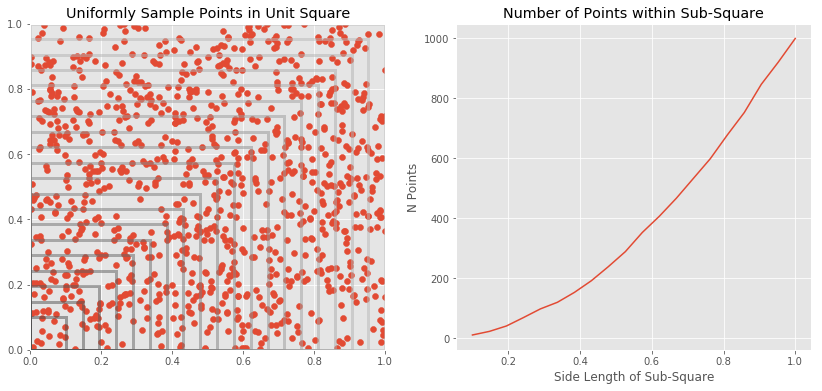

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

two_dim_data = samples[2]
ticks = np.linspace(0.1, 1, num=20)

ax = axs[0]
ax.scatter(two_dim_data[:, 0], two_dim_data[:, 1])
for edge_len in reversed(ticks):
    ax.add_patch(patches.Rectangle((0, 0), edge_len, edge_len, 
                                   color=cm.gray(0.25 + 0.5*edge_len), 
                                   linewidth=3, fill=False, alpha=0.5))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_title("Uniformly Sample Points in Unit Square")

ax = axs[1]
density = [num_points_within(two_dim_data, edge_len) for edge_len in ticks]
ax.plot(ticks, density)
ax.set_title("Number of Points within Sub-Square")
ax.set_xlabel("Side Length of Sub-Square")
ax.set_ylabel("N Points")

The curve on the right shows how the number of points in a square changes as the size of the square increases to envelop the *entire* large square.

Not let's run this simulation but **change the dimension** of the larger square.

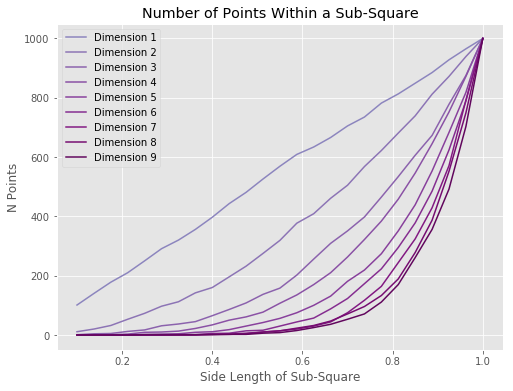

In [5]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ticks = np.linspace(0.1, 1, num=25)

for dim, sample in samples.items():
    density = [num_points_within(sample, edge_len) for edge_len in ticks]
    ax.plot(ticks, density, label="Dimension {}".format(dim), 
            color=cm.BuPu(0.5 + dim/20.0))
    
ax.legend(loc="upper left")
ax.set_title("Number of Points Within a Sub-Square")
ax.set_xlabel("Side Length of Sub-Square")
ax.set_ylabel("N Points")

In larger dimensions fewer and fewer of those data are *near* the fixed corner of the cube.

*Revisit Jack's Example*

https://github.com/zipfian/DSI_Lectures/blob/master/clustering/jfomhover/curse_of_dimensionality.ipynb

For algorithms that make predictions at $x$ by looking for training samples that are *near* $x$, we need an increasingly vast amount of data to construct accurate models.

**Discussion:** What algorithms we have studied use only points *near* $x$ to make predictions or inferences about $x$.  Which do not have this property?

### Reason to Reduce Dimensions #2:

To combat the curse of dimensionality.

### Example: Visualization of Data

In Fischer's classic iris dataset, we describe flowers by four measurements, so it is a four dimensional representation of the flowers.

![Iris Measurements](img/iris-measurements.png)

In [6]:
iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_type = iris.target
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Data of dimension larger than *two* leads to challenges for visualization.  In dimension three we can draw some plots, but they are hard to use.  In dimension four, we need **coping strategies**.

**One option** is to plot each feature against each other feature in a scatter plot.

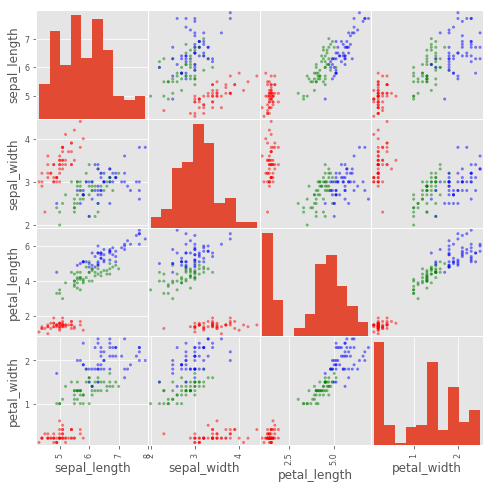

In [7]:
_ = scatter_matrix(iris_data, 
                   c=np.array(["red", "green", "blue"])[iris_type], 
                   figsize=(8, 8))

**Discussion:** How can we construct *one* scatterplot of the four-dimensional data that is in some sense the *best* way to represent it.

### Reason to Reduce Dimensions #3:

To compensate for our inability to visualize high dimensional situations.

### Introduction to Principal Component Analysis

Let's think of our data as a point cloud in $p$-dimensional space, and ask the following question:

**Fundamental Question:** How can we find a 1-dimensional data set $X_1$ so that

  - Going from $X$ to $X_1$ is a very simple operation.
  - In some sense, $X_1$ is the *best* one dimensional reconstruction of $X$.

**Discussion:** Consider "Going from $X$ to $X_1$ is a very simple operation".  What are some good candidates for *simple operations*.  The following animation may be suggestive.

![Pca Animation](img/pca.gif)

Image source: http://stats.stackexchange.com/a/140579/74500

#### One-Dimensional PCA

We look for a **line** so that the *projection* of the data $X$ onto that line

  - Results in points minimizing the total orthogonal (perpendicular) squared distance to $X$
  - Results in points with *maximum variance* as a 1-dimensional data set.

In [8]:
n_points = 75

In [9]:
def random_data_set(n=n_points):
    theta = np.random.uniform(low=0, high=2*3.14159)
    rotation = np.array([[np.cos(theta), np.sin(theta)], 
                         [-np.sin(theta), np.cos(theta)]])
    data = np.column_stack([np.random.normal(size=n), 2*np.random.normal(size=n)])
    rotated_data = data @ rotation
    return rotated_data

In [10]:
def plot_1dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component line through the orgin (green).
        - Plot the eigenvector representing the principal component (black).
        - The point cloud projected onto the principal component line (green).
    """
    X = random_data_set()
    pcd = PCA(1).fit(X)
    e = pcd.components_[0]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a line for the principal component.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e[0]*x, e[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the line.
    X_proj = X @ e
    X_reconst = np.array([t*e for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e[0], e[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

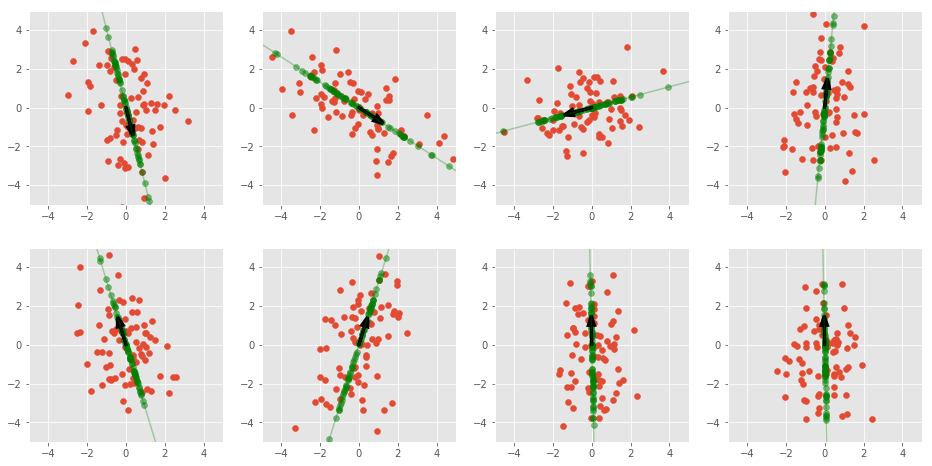

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_1dim_pca(ax)

In the above plots, we superimpose the first principal component onto a random scatter plot.  Notice that:

> The green line is chosen so that the projections of the data points onto this line are **maximally spread out**.

The direction of this line is called the **first principal component** of the data.

**Discussion:** How should we find the **second** principal component of the data set?

#### General Principal Components

**In general** PCA applied to a dataset $X$ returns the best line, plane, 3-space, 4-space, ... so that when $X$ is projected into the subspace

  - The total squared distance from the original data to the projections in minimized.
  - The total variance (i.e. the sum of the variances in all posible orthogonal directions) of the projected dataset is maximal.

In [12]:
def plot_2dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component lines through the orgin (green).
        - The eigenvectors representing the principal components (black).
        - The point cloud projected onto the principal component lines (green).
    """
    X = random_data_set()
    pcd = PCA(2).fit(X)
    e_1 = pcd.components_[0]
    e_2 = pcd.components_[1]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a lines for the principal components.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e_1[0]*x, e_1[1]*x, color='green', alpha=0.3, linestyle='-')
    ax.plot(e_2[0]*x, e_2[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the first line.
    X_proj = X @ e_1
    X_reconst = np.array([t*e_1 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot the projections of the data points onto the second line.
    X_proj = X @ e_2
    X_reconst = np.array([t*e_2 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e_1[0], e_1[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.arrow(0, 0, e_2[0], e_2[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

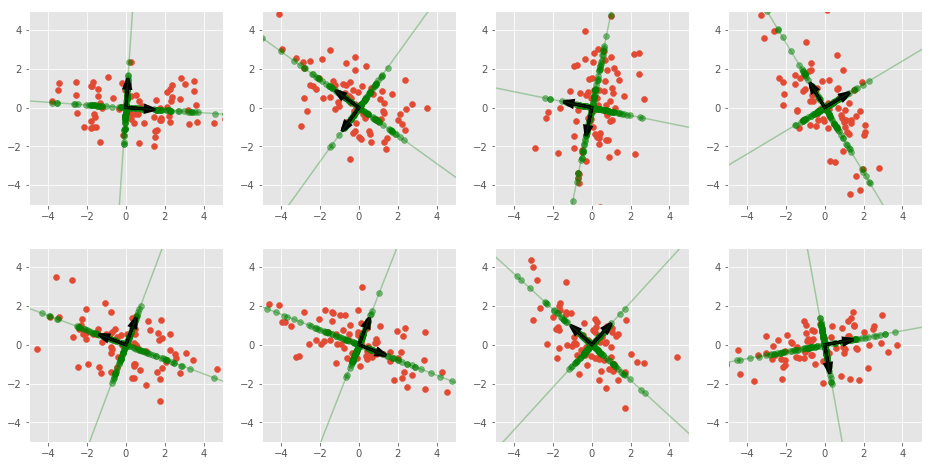

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_2dim_pca(ax)

In the above plots, we superimpose the first and second principal components onto a random scatter plot.  Notice that:

  - The **first principal component** determines a green line that maximizes the variance of the data's projection.
  - The **second principal component** is orthogonal to the first, and maximizes the projection of the "leftover" data.

### Computing Principal Components

The solution to the problem of finding principal components involves, somewhat surprisingly, the *eigenvalues* and *eigenvectors* of the covariance matrix $\frac{1}{n} X^t X$ of $X$.

**Note:** X must be centered before computing the covariance in this manner.

#### Setup:

$X$ is a dataset, which we represent as a $n \times p$ matrix of numbers.

In [14]:
X = random_data_set(n=50)
X[:5, :]

array([[ 1.72638175,  0.49820359],
       [-0.0079398 , -0.66944614],
       [-0.55457721, -0.53733641],
       [ 0.57387741, -5.26708739],
       [ 0.88474303, -0.74347378]])

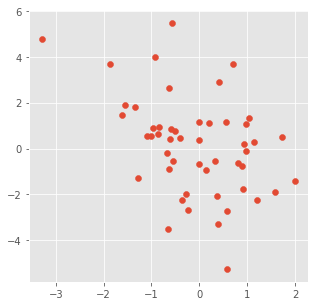

In [15]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1])

#### Step 1: Center the Matrix.

**Centering** the matrix is the process of subracting the column means from the columns themselves.  This results in a new matrix with column means zero.

In [16]:
np.mean(X, axis=0)

array([-0.10034701,  0.16042592])

In [17]:
X_centered = X - np.mean(X, axis=0)
print(np.mean(X_centered, axis=0))

[ -3.55271368e-17  -5.32907052e-17]


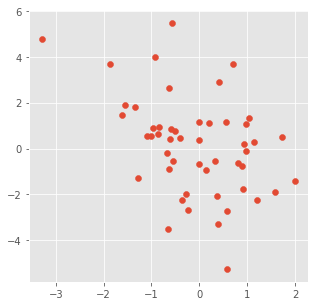

In [18]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1])

#### Step 2: Compute the sample covariance matrix.

The covariance matrix of the sample is $M = \frac{1}{n} X^t X$.

In [19]:
M = X.T @ X * (1/float(X.shape[0]))
M

array([[ 1.05202589, -0.93193007],
       [-0.93193007,  4.61271246]])

The diagonal terms of the covariance matrix are the variance of the first and second columns. The cross terms show the interactions, showing how much one the mean of one feature changes with a change in the mean of another.

#### Step 3: Compute the Eigenvectors and Eigenvalues of M.

The eigenvectors, when ordered in order of decreasing eigenvalue, are the principal components of $X$.

**Note:**
  - Since $M$ is a symmetric, it has a full set of $p$ eigenvectors.
  - Since $M$ is non-negative definite,  the eigenvalues are non-negative numbers.

In [20]:
e_values, e_vectors = eig(M)
print("The eigenvectors of M are:")
print(e_vectors)
print("The eigenvlaues of M are {}".format(e_values))

The eigenvectors of M are:
[[-0.9710717   0.23878808]
 [-0.23878808 -0.9710717 ]]
The eigenvlaues of M are [ 0.8228628   4.84187555]


### Intermission: Eigenvectors

Recall that the **eigenvectors** of $M$ are vectors $v$ that satisfy a relationship like:

$$ M v = \lambda v $$

I.e., the matrix $M$ acts as a **scaling** on the vector $v$.

In [21]:
(M @ e_vectors[:, 0]) / e_vectors[:, 0]

array([ 0.8228628,  0.8228628])

In [22]:
(M @ e_vectors[:, 1]) / e_vectors[:, 1]

array([ 4.84187555,  4.84187555])

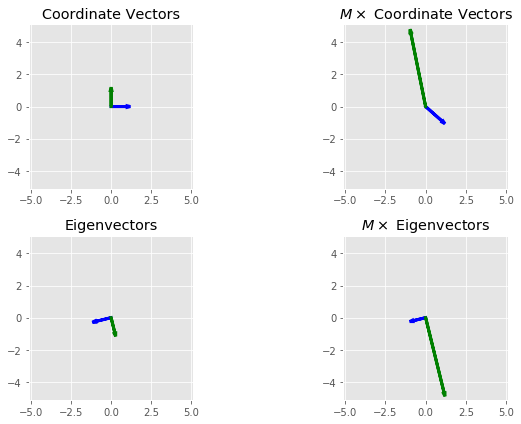

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), )

coord_vectors = np.array([[1, 0], [0, 1]])
coord_image = M @ coord_vectors
e_image = M @ e_vectors

# Set coordinate ranges to the maximal possible arrow position
max_coord = max(np.max(coord_vectors), np.max(coord_image), np.max(e_image))
for ax in axs.flatten():
    ax.set_xlim(-max_coord - 0.5, max_coord + 0.5)
    ax.set_ylim(-max_coord - 0.5, max_coord + 0.5)
    ax.set(adjustable='box-forced', aspect='equal')


# Plot the coordiante vectors and thier images.
axs[0, 0].arrow(0, 0, coord_vectors[0, 0],  coord_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 0].arrow(0, 0, coord_vectors[0, 1], coord_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 0].set_title("Coordinate Vectors")
axs[0, 1].arrow(0, 0, coord_image[0, 0],  coord_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 1].arrow(0, 0, coord_image[0, 1], coord_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 1].set_title("$M \\times$ Coordinate Vectors")


# Plot the eigenvectors and thier images.
axs[1, 0].arrow(0, 0, e_vectors[0, 0],  e_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 0].arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 0].set_title("Eigenvectors")
axs[1, 1].arrow(0, 0, e_image[0, 0],  e_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 1].arrow(0, 0, e_image[0, 1], e_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 1].set_title("$M \\times$ Eigenvectors")

plt.tight_layout()

Above, we see that the effect of multiplying the matrix $M$ by coordinate vectors is difficult to understand, the coordinate vectors are rotated and scaled, each by a different amount.

On the other hand, the eigenvectors of $M$ are much better behaved when multiplied by $M$, the direction of the eigenvectors are preserved, but they are stretched or shrunk.

Let's plot the eigenvectors of $M$ on top of the centered data set to see how they relate to the scatterplot of the data

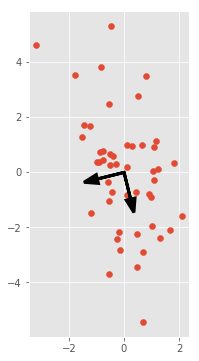

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(X_centered[:, 0], X_centered[:, 1])
ax.arrow(0, 0, e_vectors[0, 0], e_vectors[1, 0],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
ax.arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
_ = ax.set(adjustable='box-forced', aspect='equal')

### Summary:

  - The Principal Components algorithm computes the *eigenvectors* and *eigenvalues* of the matrix $X^t X$.
  - Each eigenvector is called a *principal component* of $X$.
  - Projecting onto the first $k$ principal components creates the **best k dimensional reconstruction of the data**.

## PCA In Practice

In practice, we use `sklearn.decomposition.PCA` to find principal components.

In [25]:
pcd = PCA(2).fit(X)

Sklearn returns a `PCA` returns an object with a `components_` attribute.

In [26]:
pcd.components_

array([[ 0.23620041, -0.97170436],
       [-0.97170436, -0.23620041]])

The `components_` attribute is an orthogonal matrix containing (as rows) the eigenvalues of the correlation matrix.  That is, the *principal components*.

Let's call the matrix of principal components $E$.

### Properties of Principal Components

1. Taking the first $k$ rows of $E$ gives (a basis for) the "best" $k$ dimensional subspace.  We call this subset matrix $E_{1:k}$.

2. "Best" above means: projecting the dataset onto this subspace preserves the **most variance in the data** out of all possible such projections.

3. The matrix multiplication $XE_{1:k}^t$ gives the *coefficients* of the "best" reconstruction of $X$ in the basis $E_k$.

4. The matrix multiplication $(X E_{1:k}^t) E_{1:k}$ gives the "best" reconstruction of $X$ as a $k$ dimensional object.  That is, this reconstructs $X$ as a matrix with $k$ columns.

Additionally, the `explained_variance_` attribute contains the total variance of the *projected* dataset.

Each of the numbers in `explained_variance_` is an *eigenvalue* of the covariance matrix $X^t X$.

5. The **eigenvalues** of the covariance matrix measure the variance of the projection of the data onto the associated eigenvector (principal component).

**Exercise:** Using the $X$ data above, what fraction of the variance is explained by the first principal component.

### What Principal Component Analysis IS For

So, **the purpose of PCA is to approximately reconstruct data sets as a lower dimensional object.**

Applications of this include:

  - Visualization.
  - Clustering.
  - Data Compression.
  - Mathematical analysis of the properties of regression modeling.

### Example: The Best Scatterplot of Iris

Let's construct a "best" scatterplot of the iris dataset using PCA to project

```
Four dimensional iris data => Best two dimensional reconstruction
                           => Best two dimensional scatterplot
```

In terms of the above discussion we are plotting the *expression of $X$ in the principal component basis*.

$$ X E_{1:2}^t $$

In [27]:
pcd = PCA(2).fit(iris_data.values)
iris_reduced = iris_data.values @ pcd.components_.T

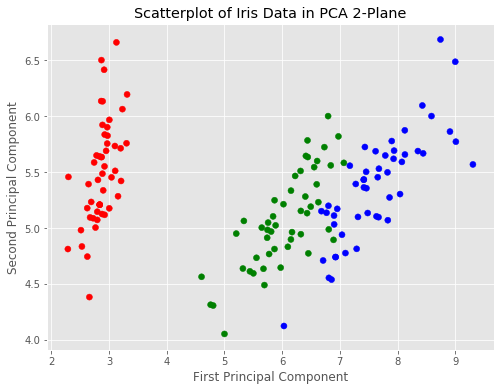

In [28]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(iris_reduced[:, 0], iris_reduced[:, 1], 
           color=np.array(["red", "green", "blue"])[iris_type])
ax.set_title("Scatterplot of Iris Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

**Discussion:** Does PCA find the plain in which the different categories are the most clearly distinguished?

### Example: Eigenfaces: Reconstructing Faces.

As an example of *very* high dimensional data, we introduce the `faces` data set.

An extended version of this example is available in the sklearn docs here: http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [29]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# Global centering
faces_centered = faces - faces.mean(axis=0)

# Local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [30]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

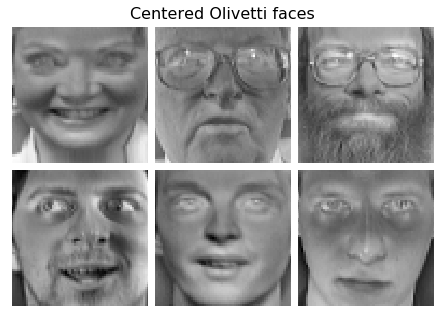

In [31]:
plot_gallery("Centered Olivetti faces", faces_centered[:n_components])

Each of these images is stored as a numpy array.

Each entry in the array measures *one* pixel intensity.

[[-0.05288465 -0.07872145 -0.09184127 ..., -0.07057048  0.0761445
   0.11743565]
 [-0.03018858 -0.04831843 -0.0698887  ..., -0.06516771  0.05821054
   0.10930555]
 [-0.03242992 -0.08290516 -0.05704789 ..., -0.07283308  0.0611238
   0.10700177]
 ..., 
 [ 0.54305553  0.53032815  0.52888185 ...,  0.46428466  0.43686754
   0.41230136]
 [ 0.53049362  0.52165043  0.52055538 ...,  0.46218783  0.4446876
   0.4059273 ]
 [ 0.52397507  0.51765269  0.51337576 ...,  0.45558649  0.44682604
   0.40869588]]


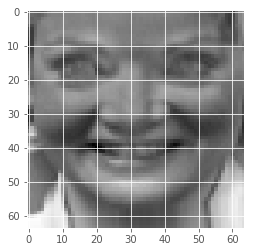

In [32]:
first_face = faces_centered[0].reshape(image_shape)
print(first_face)
plt.imshow(first_face, cmap=cm.gray)

Don't believe me?

In [33]:
first_face_ascii = np.array(['#', '.'])[(first_face >= 0).astype(int).flatten()].reshape(image_shape)
print('\n'.join([''.join(row) for row in first_face_ascii]))

######........................................################..
######........................................################..
####..........................................################..
####........................................#.################..
###...................................##.#...##.##############..
###...................................##...............########.
###....................................................########.
###.................................................##.########.
###.............................................###############.
##.......######................................###############.#
##....#......########...........##.......########.......######.#
##............#########.....#########..###############..###....#
##.........#############..#################################.....
##......###################################################.....
##....################.#####.###############################....
##....################..#

Each image is a $64 \times 64$ array, and so is represented as a $4096$ dimensional object.

**Discussion:** Do you really believe that faces are $4096$ dimensional objects?

Let's apply PCA to the faces dataset to lower the dimensionality.

In [34]:
faces_pcd = PCA(100).fit(faces_centered)

The columns in the $E^t$ matrix (i.e. `faces_pcd.components_.T`) are called **eigenfaces**.

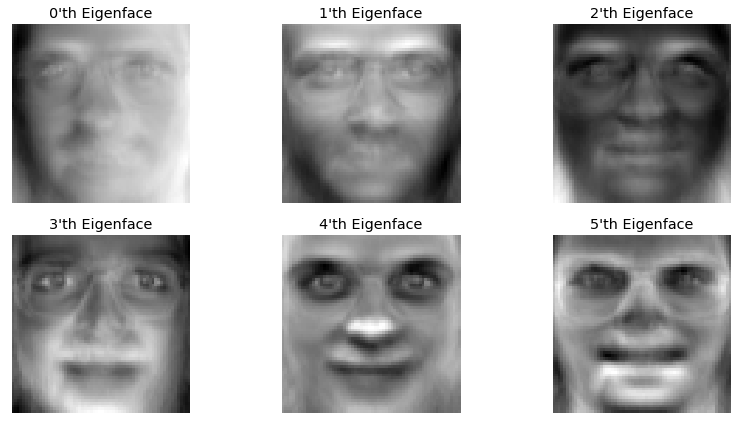

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, i in zip(axs.flatten(), range(6)):
    eigenface = faces_pcd.components_[i, :].reshape(image_shape)
    ax.imshow(eigenface, cmap=cm.gray)
    ax.set_title("{}'th Eigenface".format(i))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Question:** What facial features seem to be captured in the first few eigenfaces?  Why do you think this may be so?

Let's do our reconstruction procedure with the face data.  This lets us create **smaller dimensional faces**.

In [36]:
def reduce_face_data(n_dim):
    eigenvalues = faces_pcd.components_[:n_dim, :].T
    faces_reduced = faces_centered @ eigenvalues @ eigenvalues.T
    return faces_reduced

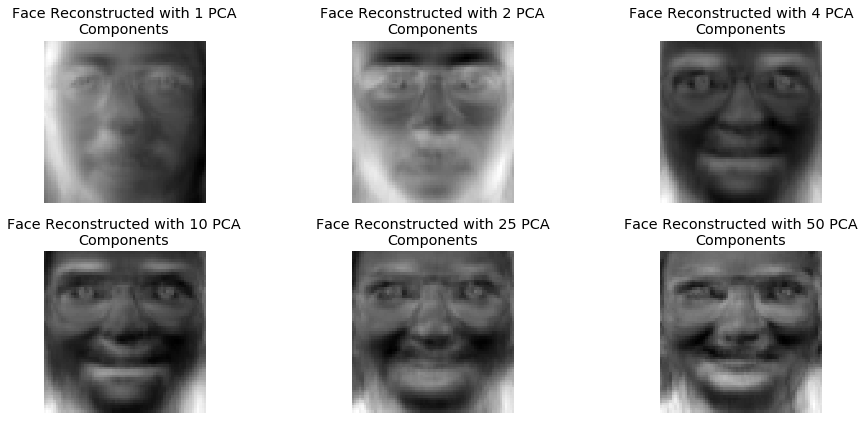

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    reduced_data = reduce_face_data(dim)
    first_face = reduced_data[0].reshape(image_shape)
    ax.imshow(first_face, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} PCA\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Discussion:** When applying PCA to reduce the dimensionality of a data set, we have to choose a *number of dimensions* to keep.  What kind of concerns should we consider when choosing this number?

### What Principal Componenets Analysis is NOT for

There is an, unfortunately, popular method which combines PCA with regression, with the intent of improving the generalization properties of the regression.  It is called **Principal Component Regression** and it goes like this:

**Setup**: You have a matrix $X$ and a response $y$, and you want to fit a regression to predict $y$ from $X$.

**Procedure**:
1. Do PCA on $X$, let $E$ be the matrix of principal components.
2. Discard some of the principal components, get the matrix $E_{1:k}$.
3. Regress $y$ on $E_{1:k}$.

**Discussion:** Critique this procedure, pros and cons.

For details on why **not** to use selection of principal components as a regularization strategy in regression [see this paper](http://www.uvm.edu/~rsingle/stat380/F04/possible/Hadi%2BLing-AmStat-1998_PCRegression.pdf) and [this paper](http://automatica.dei.unipd.it/public/Schenato/PSC/2010_2011/gruppo4-Building_termo_identification/IdentificazioneTermodinamica20072008/Biblio/Articoli/PCR%20vecchio%2082.pdf).

[This question](http://stats.stackexchange.com/questions/101485/examples-of-pca-where-pcs-with-low-variance-are-useful) gives real life examples of data sets where PCR fails because $y$ is only related to the **low variance** principal components.

The moral of this story: PCA is reasonable as a variable creation strategy only when you have a good reason to believe that there are low variance components in $X$ that will *not* contribute to prediction.

**Discussion:** Why is PCA **not** a variable selection algorithm.

## Singular Value Decomposition - Afternoon Lecture

**Opening Question:** http://stats.stackexchange.com/questions/239518/logistic-regression-with-lasso-versus-pca

### The Singular Value Decomposition

There is a matrix factorization closely related to PCA, the SVD decomposition.

**Any** $n \times p$ matrix $X$ can be factored as follows

$$ X = U S V $$

Where

  - $U$ is a $n \times n$ orthogonal matrix.
  - $S$ is a $n \times p$ matrix with non-zero entries on the diagonal *only*.
  - $V$ is a $p \times p$ orthogonal matrix.

### Intermission: Orthogonal Matricies

An **orthogonal matrix** is one with the following property:
    
> Any vector $v$, when multiplied by an orthogonal matrix, is simply rotated.

We say that an orthogonal matrix **acts as a rotation**.

It's easy to crate $2 \times 2$ orthogonal matrices.  For any angle $\theta$, the matrix

$$ M_{\theta} =  \left( \begin{array}{cc} 
\cos \theta & - \sin \theta  \\       
sin \theta & cos \theta \\
\end{array} \right) $$

is orthogonal.  

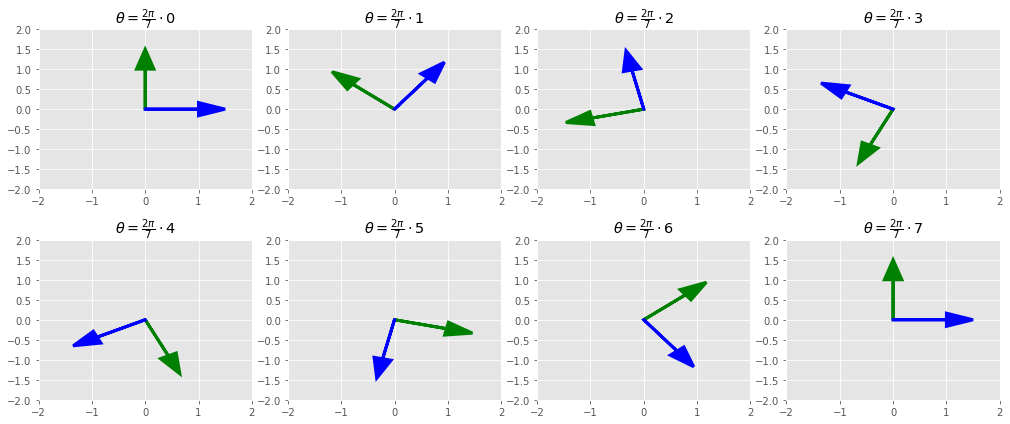

In [38]:
thetas = np.linspace(0, 2*np.pi, num=8)
coord_vectors = np.array([[1, 0], [0, 1]])


fig, axs = plt.subplots(2, 4, figsize=(14, 6))

for i, (theta, ax) in enumerate(zip(thetas, axs.flatten())):
    M = np.array([[-np.sin(theta), np.cos(theta)], 
                  [np.cos(theta), np.sin(theta)]])
    image_vectors = M @ coord_vectors
    ax.arrow(0, 0, image_vectors[0, 0], image_vectors[1, 0],
            head_width=0.33, linewidth=3, head_length=0.5, fc='g', ec='g')
    ax.arrow(0, 0, image_vectors[0, 1], image_vectors[1, 1],
            head_width=0.33, linewidth=3, head_length=0.5, fc='b', ec='b')
    ax.set_title("$\\theta = \\frac{{2\\pi}}{{7}} \\cdot {}$".format(i))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
plt.tight_layout()

A closely related, and more common, definition of an orthogonal matrix is the following:
    
> An orthogonal matrix $M$ is any matrix satisfying the equation $M^t M = I$.

**Exercise**: Verify that the $2 \times 2$ matrix of sins and cosines above is orthogonal by computing $M_{\theta}^t M_{\theta}$ and using some basic trigonometric identities.

So the SVD decomposition:
    
$$ X = U S V $$

factors $X$ as three matrices:
    
  - $V$ is orthogonal, hence a rotation, followed by...
  - $S$ is quasi diagonal, so a scaling, followed by...
  - $U$ is orthogonal, so a rotation.

![SVD decomposition](img/svd.png)

Image Source: https://en.wikipedia.org/wiki/Singular_value_decomposition

The $S$ matrix has positive diagonal entries, these are called the **singular values** of $X$, they are closely related to eigenvalues.

So, for a $4 \times 2$ matrix $X$, the singular value matrix would look like:

$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0  \\       
0 & \sigma_2 \\
0 & 0 \\
0 & 0 \\
\end{array} \right) $$

and for a $6 \times 3$ like:

$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0 & 0  \\       
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{array} \right) $$

### Example: Image Reconstruction From Singular Values

Recall how we used PCA to "approximately reconstruct" a matrix $M$ from its first few principal components.  We can do the same thing with SVD

$$ X \approx U S_{k} V $$

Here, $S_{k}$ is the matrix created from $S$ by setting **all but the first $k$ singular values to zero**.

In an earlier example we reconstructed faces with only the first few principal components, here we reconstruct a face with only the first few **singular values**.

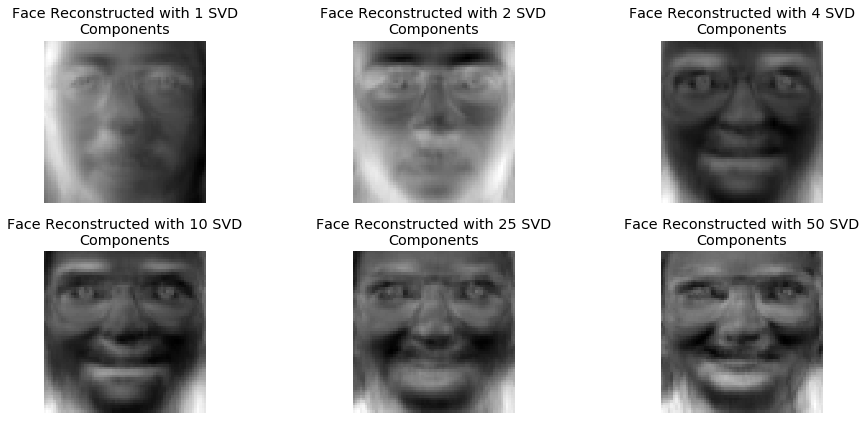

In [39]:
ig, axs = plt.subplots(2, 3, figsize=(13, 6))
U, S, VT = svd(faces_centered)

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    S_reduced = np.zeros(faces_centered.shape)
    np.fill_diagonal(S_reduced, S)
    # Set all but first dim singular values equal to zero.
    S_reduced[:, dim:] = 0
    faces_reconstructed = U @ S_reduced @ VT
    first_face_reconstructed = faces_reconstructed[0].reshape(image_shape)
    ax.imshow(first_face_reconstructed, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} SVD\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()

If you scroll up to the PCA reconstructed faces from before, these look remarkably similar, hinting at a deeper connection.

## SVD for topic analysis

We can use SVD to determine what we call ***latent features***. This will be best demonstrated with an example.

### Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

|       | Matrix | Alien | StarWars | Casablanca | Titanic |
| ----- | ------ | ----- | -------- | ---------- | ------ |
| **Alice** |      1 |     2 |        2 |          0 |      0 |
|   **Bob** |      3 |     5 |        5 |          0 |      0 |
| **Cindy** |      4 |     4 |        4 |          0 |      0 |
|   **Dan** |      5 |     5 |        5 |          0 |      0 |
| **Emily** |      0 |     2 |        0 |          4 |      4 |
| **Frank** |      0 |     0 |        0 |          5 |      5 |
|  **Greg** |      0 |     1 |        0 |          2 |      2 |

Note that the first three movies (Matrix, Alien, StarWars) are Sci-fi movies and the last two (Casablanca, Titanic) are Romance. We will be able to mathematically pull out these topics!

Let's do the computation with Python.

In [40]:
rating_matrix = np.array([
              [1, 2, 2, 0, 0],
              [3, 5, 5, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

movies = ['TheMatrix', 'Alien', 'StarWars', 'Casablanca', 'Titanic']
users = ['Alice', 'Bob', 'Cindy', 'Dan', 'Emily', 'Frank', 'Greg']
ratings_df = pd.DataFrame(rating_matrix, index=users, columns=movies)
print(ratings_df)

       TheMatrix  Alien  StarWars  Casablanca  Titanic
Alice          1      2         2           0        0
Bob            3      5         5           0        0
Cindy          4      4         4           0        0
Dan            5      5         5           0        0
Emily          0      2         0           4        4
Frank          0      0         0           5        5
Greg           0      1         0           2        2


Numpy can compute the full SVD.

In [41]:
U, sigma, VT = svd(rating_matrix)

In [42]:
U, sigma, VT = (np.around(x, 2) for x in (U, sigma, VT))

U_df = pd.DataFrame(U, index=users)
VT_df = pd.DataFrame(VT, columns=movies)

In [43]:
print(U_df.shape)
print(sigma.shape)
print(VT_df.shape)

(7, 7)
(5,)
(5, 5)


The VT matrix has columns indexed by movies.

In [44]:
print(VT_df)

   TheMatrix  Alien  StarWars  Casablanca  Titanic
0      -0.50  -0.62     -0.60       -0.06    -0.06
1       0.09  -0.05      0.11       -0.70    -0.70
2      -0.78   0.62      0.03       -0.07    -0.07
3      -0.36  -0.48      0.79        0.05     0.05
4       0.00   0.00      0.00       -0.71     0.71


We can interpret the *rows* of this matrix as some latent features.  There is *something* about these movies that is

  - Being measured in each row.
  - Being inferred from how users rated the movies as a whole.

For example, the **first row** seems to draw a strong distinction between science fiction and romantic movies.

The U matrix has rows indexed by *users*.

In [45]:
print(U_df)

          0     1     2     3     4     5     6
Alice -0.21  0.02  0.31  0.26 -0.52 -0.70  0.17
Bob   -0.55  0.06  0.53  0.46  0.26  0.35 -0.09
Cindy -0.50  0.07 -0.31 -0.20  0.61 -0.48  0.12
Dan   -0.62  0.08 -0.39 -0.24 -0.54  0.31 -0.08
Emily -0.12 -0.60  0.40 -0.52 -0.00 -0.10 -0.43
Frank -0.04 -0.73 -0.42  0.53  0.00 -0.00  0.00
Greg  -0.06 -0.30  0.20 -0.26 -0.00  0.21  0.87


Each of the rows in this matrix contains *weights*, they measure how important each *latent feature* is to each user's ratings.

**Note:** that the last two columns of this matrix *do not matter* for reconstructing X.  These are the columns for which the associated rows of the singular value matrix are **completely zero**.

If we want to figure out an approximation of the user's rating of the movies using **only** the first two latent features, we can zero out all but the first two singular values.

In [46]:
# Zero out all but the first two singular values
sigma_reduced = np.zeros(rating_matrix.shape)
np.fill_diagonal(sigma_reduced, sigma)
sigma_reduced[:, 2:] = 0

# Reoconstruct the ratings matrix
ratings_reconstructed = U @ sigma_reduced @ VT

ratings_reconstructed_df = pd.DataFrame(ratings_reconstructed, index=users, columns=movies)
print(ratings_reconstructed_df)
print(ratings_df)

       TheMatrix     Alien  StarWars  Casablanca   Titanic
Alice   1.470336  1.792448  1.764784    0.041104  0.041104
Bob     3.857408  4.690880  4.630032    0.056880  0.056880
Cindy   3.519976  4.257080  4.225304   -0.051280 -0.051280
Dan     4.358944  5.282016  5.232256   -0.018272 -0.018272
Emily   0.316320  1.315296  0.368160    4.098048  4.098048
Frank  -0.348664  0.690712 -0.432296    4.897936  4.897936
Greg    0.158160  0.657648  0.184080    2.049024  2.049024
       TheMatrix  Alien  StarWars  Casablanca  Titanic
Alice          1      2         2           0        0
Bob            3      5         5           0        0
Cindy          4      4         4           0        0
Dan            5      5         5           0        0
Emily          0      2         0           4        4
Frank          0      0         0           5        5
Greg           0      1         0           2        2


This seems to be a pretty good reconstruction of the ratings matrix, even though we only kept two singular values.

If we investigate, the first two singular values are by far the largest:

In [47]:
print(sigma)

[ 13.84   9.52   1.69   1.02   0.  ]


We seem to have picked up some **negative** ratings, which is weird.  Tomorrow we will study a procedure to fix this issue.

### The Relationship Between PCA and SVD

The PCA algorithm can be expressed pithily as the following matrix equation

$$ X^t X = E^t D E $$

where

  - $E$ is the matrix of eigenvectors of $X^t X$ (i.e. principal components, stored in the rows as `sklearn` does).
  - $D$ is a *diagonal* matrix.  The diagonal entries are the eigenvalues of $X^t X$.
  
See the appendix to the lecture for a proof of this fact.

Suppose that we factor $X$ into its singular value decomposition

$$ X = U S V $$

We can plug this into $X^t X$ and derive a relationship between PCA and the SVD factorization.

$$ X^t X = (U S V^t)^t (U S V^t) = V S^t U^t U S V^t $$

But $U$ is orthogonal, so the inner $U^t U$ is the identity matrix:

$$ X^t X = V S^t S V^t $$

Recall that $S$ is $n \times p$ a matrix like this:
    
$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0 & 0  \\       
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{array} \right) $$



**Exercise**: Compute $S^t S$ for this matrix.

So, $S^t S$ is a $p \times p$ matrix like this:
    
$$ S =  \left( \begin{array}{cc} 
\sigma_1^2 & 0 & 0  \\       
0 & \sigma_2^2 & 0 \\
0 & 0 & \sigma_3^2 \\
\end{array} \right) $$

Comparing the two expressions for $X^t X$

#### PCA

$$ X^t X = E^t D E $$

#### SVD

$$ X^t X = V S^t S V^t $$

We deduce the following

#### Relationship between PCA and SVD

$$ E^t = V $$
$$ D = S^t S $$

So the **eigenvectors** from PCA are the **columns** of the matrix V.

And, the **eigenvalues** from PCA are the **squares of the singular values**.

### Why PCA With SVD?

While the above shows its **possible** to compute the principal components with SVD, it does not argue that it is **beneficial**.  Let's look at a hypothetical example.

Suppose our data set $X$ contains gray-scale image data:

  - $500$ images.
  - Each image is $200 \times 200$ pixels.  So, $40,000$ total pixels.

Therefore, $X$ is a $500 \times 40,000$ matrix.  Many, many more columns than rows.

**Note:** This is commonly called the $p \gg n$ situation.

Now, **PCA** needs to compute the matrix $X^t X$.

This is a $40,000 \times 40,000$ matrix, so it has $1,600,000,000 = 1.6 \times 10^9$ entries.

One floating point number is:
  - $64$ bits (on a modern computer)
  - $8$ bytes (each byte is $8$ bits).

So, $X^t X$ takes

$$ 8 \times 1.6 \times 10^9 = 12.8 \times 10^9 $$

bytes of data to store.  This is $12.8$ gigabytes.  **A huge amount of data**.

SVD **does not have to compute the $X^t X$ matrix, it operates completely on $X$ itself**.  Much more efficient.